## 1. Introduction

## 2. Data Import


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import warnings
import seaborn as sns
import numpy as np
import time
import optuna
from collections import Counter
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, recall_score, roc_auc_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.mixture import GaussianMixture


# library for imbalanced data
from imblearn.pipeline import Pipeline as ImbPipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import pandas as pd
import os
import re
import seaborn as sns
from seaborn import heatmap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'optuna'

In [4]:
# Load in the training and testing datasets
train_path = os.path.join("Dataset", "diabetic_data_training.csv")
test_path = os.path.join("Dataset", "diabetic_data_test.csv")
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

## 3. Data Transformation & Exploration


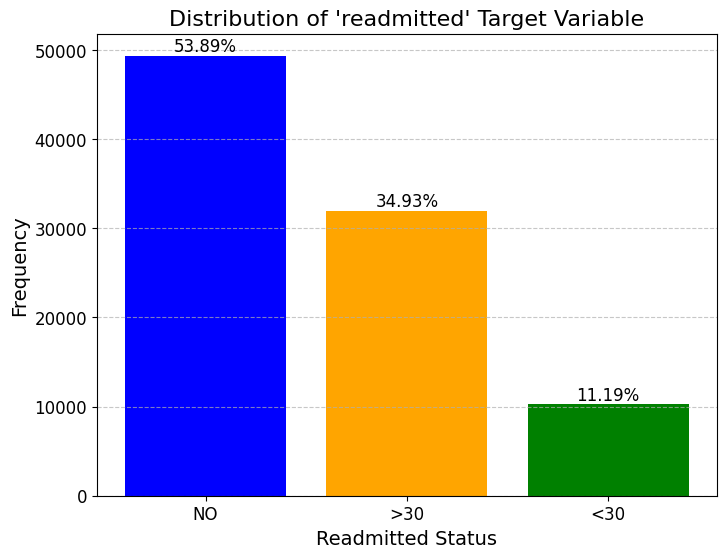

In [9]:
def plotReadmittedDistribution():
    '''
    Function to plot the distribution of the 'readmitted' target variable
    '''

    readmitted_counts = df_train['readmitted'].value_counts()
    readmitted_percentages = (readmitted_counts / len(df_train)) * 100

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    bars = plt.bar(readmitted_counts.index, readmitted_counts, color=['blue', 'orange', 'green'])
    plt.title("Distribution of 'readmitted' Target Variable", fontsize=16)
    plt.xlabel("Readmitted Status", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Annotate bars with percentages
    for bar, percentage in zip(bars, readmitted_percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plotReadmittedDistribution()

In [ ]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        """
        Custom transformer to drop specified columns.
        :param columns_to_drop: List of column names to drop
        """
        self.columns_to_drop = columns_to_drop if columns_to_drop else []

    def fit(self, X, y=None):
        # Nothing to fit; just return self
        return self
    
    def transform(self, X):
        """
        Drop the specified columns from the DataFrame.
        :param X: Input DataFrame
        :return: Transformed DataFrame with specified columns dropped
        """
        return X.drop(columns=self.columns_to_drop)
    
class DropRowsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, conditions=None):
        """
        Custom transformer to drop rows based on specified conditions.
        :param conditions: List of conditions (functions) to drop rows
        """
        self.conditions = conditions if conditions else []

    def fit(self, X, y=None):
        # Nothing to fit; just return self
        return self
    
    def transform(self, X):
        """
        Drop rows based on specified conditions.
        :param X: Input DataFrame
        :return: Transformed DataFrame with rows dropped based on conditions
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")
        for condition in self.conditions:
            X = X[~condition(X)]
        return X
    
class ModelImputationTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses a multi-output model (e.g., MultiOutputClassifier)
    to impute missing values for specified target columns.
    """

    def __init__(self, target_features=None, base_model=None):
        """
        :param target_features: list[str], the names of the columns to be imputed.
        :param base_model: The classifier (or regressor) to be used. 
                          Defaults to MultiOutputClassifier(LogisticRegression()).
        """
        self.target_features = target_features or []
        self.base_model = base_model or MultiOutputClassifier(LogisticRegression())
        self.input_features_ = None  # Will be inferred at fit time
        self.fitted_model_ = None

    def fit(self, X, y=None):
        """
        In the fit phase, select rows where the target_features are not missing
        and use them to train the model.
        """
        # 1) Copy X to avoid modifying it in place
        df = X.copy()
        # 2) Input features = all columns in X that are not in target_features
        #    (Assuming target_features exist in X)
        self.input_features_ = [col for col in df.columns if col not in self.target_features]
        # 3) Filter rows where all target_features are non-missing (for training)
        train_data = df.dropna(subset=self.target_features)
        X_train = train_data[self.input_features_]
        y_train = train_data[self.target_features]
        # 4) Train the multi-output model
        self.base_model.fit(X_train, y_train)
        self.fitted_model_ = self.base_model  # Store the trained model for use in transform

        return self

    def transform(self, X):
        """
        In the transform phase, use the trained model to predict and fill in 
        missing values for the target_features.
        """
        if self.fitted_model_ is None:
            # If transform is called before fit, choose to either return X or raise an error
            return X  

        df = X.copy()
        # 1) Identify rows where any of the target_features are missing
        missing_mask = df[self.target_features].isna().any(axis=1)
        test_data = df[missing_mask]

        # 2) If there are no missing values, simply return df
        if test_data.empty:
            return df
        
        # 3) Predict values for rows with missing data
        X_test = test_data[self.input_features_]
        y_pred = self.fitted_model_.predict(X_test)

        # 4) Fill in the predicted values
        for idx, col in enumerate(self.target_features):
            # Find rows where the current column is missing
            col_nan_mask = test_data[col].isna()
            # Assign the predicted values to those rows
            test_data.loc[col_nan_mask, col] = y_pred[col_nan_mask, idx]

        # 5) Update df with the newly imputed values
        df.loc[missing_mask, self.target_features] = test_data[self.target_features]
        return df

class EncodeRaceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="race"):
        """
        Custom transformer to encode the race column.
        :param column: The column name to encode.
        """
        self.column = column
        self.race_map = {
            "Caucasian": 0,
            "Asian": 1,
            "AfricanAmerican": 2,
            "Hispanic": 3,
            "Other": 4,
            "?": -1
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        :param X: Input DataFrame
        :return: Transformed DataFrame with the encoded column.
        """
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].fillna(-99)
            X[self.column] = X[self.column].map(self.race_map).astype(int)

        return X
    
class EncodeRaceImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="race"):
        """
        Custom transformer to encode the race column.
        :param column: The column name to encode.
        """
        self.column = column
        self.race_map = {
            "Caucasian": 0,
            "Asian": 1,
            "AfricanAmerican": 2,
            "Hispanic": 3,
            "Other": 4,
            "?": None
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        :param X: Input DataFrame
        :return: Transformed DataFrame with the encoded column.
        """
        X = X.copy()
        if self.column in X:
            #X[self.column] = X[self.column].fillna(-1)
            X[self.column] = X[self.column].map(self.race_map)#.astype(int)

        return X
        
class EncodeGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="gender"):
        """
        Encodes gender column
        """
        self.column = column
        self.gender_map = {
            "Female": 0, 
            "Male": 1, 
            "Unknown/Invalid": -1
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        """
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].fillna(-99) 
            X[self.column] = X[self.column].map(self.gender_map).astype(int)

        return X
    
class EncodeGenderImputationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="gender"):
        """
        Encodes gender column
        """
        self.column = column
        self.gender_map = {
            "Female": 0, 
            "Male": 1, 
            "Unknown/Invalid": None
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Encode the specified column using the predefined mapping.
        """
        X = X.copy()
        if self.column in X:
            #X[self.column] = X[self.column].fillna(-1) 
            X[self.column] = X[self.column].map(self.gender_map)#.astype(int)

        return X
    
class EncodeAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="age"):
        """
        Encodes age column
        """
        self.column = column
        self.age_map = {
            "[0-10)": 0,
            "[10-20)": 10,
            "[20-30)": 20,
            "[30-40)": 30,
            "[40-50)": 40,
            "[50-60)": 50,
            "[60-70)": 60,
            "[70-80)": 70,
            "[80-90)": 80,
            "[90-100)": 90
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.age_map).astype(int)

        return X
    
class AdmissionTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="admission_type_id"):
        """
        Group different admission_type_id into 5 classes based on the original type,
        which contains 8 categories. The mapping is as follows:
            - Class 0 : Emergency
            - Class 1 : Elective - Planned admissions.
            - Class 2 : Newborn - Admissions for newborns.
            - Class 3 : Not Available and NULL - Missing information about admission type.
            - Class 4 : Trauma Center
            - Class 5 : Not Mapped
        """
        self.column = column
        self.admission_type_id_map = {
            1: 0,  # Emergency
            2: 0,  # Urgent
            3: 1,  # Elective
            4: 2,  # Newborn
            5: 3,  # Not Available
            6: 3,  # NULL
            7: 4,  # Trauma Center
            8: 5   # Not Mapped
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.admission_type_id_map)

        return X
        
class DischargeDispositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="discharge_disposition_id"):
        """
        Group different discharge_disposition_id into 13 classes based on the original type,
        which contains 30 categories. The mapping is as follows:
            - Class 0 : Home-Based Care: Represents situations where the patient is discharged to their home environment. (1, 6, 8)
            - Class 1 : Hospice Care: Represents patients who were transferred to receive end-of-life care in a home or facility. (13, 14)
            - Class 2 : Rehabilitation/Long-Term Care: Represents patients transferred to a facility for ongoing care, rehabilitation, or specialized nursing. (3, 4, 15, 22, 23, 24, 30)
            - Class 3 : Transferred to Another Institution for Continued Care: Represents transfers to other institutions where further but similar levels of care are continued. (2, 5, 27, 29)
            - Class 4 : Transferred for Specialized or Critical Care: Represents patients transferred for more specialized care or critical conditions. (28, 7)
            - Class 5 : Neonatal Aftercare: Represents newborn patients discharged to a specialized neonatal care unit. (10)
            - Class 6 : Psychiatric Care: Represents patients discharged to a psychiatric hospital or distinct psychiatric unit. (28)
            - Class 7 : Outpatient Referral: Represents cases where the patient is discharged with a recommendation to continue treatment as an outpatient. (16, 17)
            - Class 8 : Expired: Represents patients who passed away during the course of treatment. (11, 19, 20, 21)
            - Class 9 : Ongoing Care: Represents patients who are still in care or expected to return for further treatment. (12)
            - Class 10 : Left AMA: Represents patients who left the hospital against medical advice. (7)
            - Class 11 : Not Mapped: Represents discharge types that do not match any pre-defined categories in the system. (25)
            - Class 12 : Unknown/Invalid: Represents instances where discharge information is unknown or invalid. (18, 26)
        """
        self.column = column
        self.discharge_disposition_mapping = {
            1: 0, 6: 0, 8: 0,  # Home-Based Care
            13: 1, 14: 1,      # Hospice Care
            3: 2, 4: 2, 15: 2, 22: 2, 23: 2, 24: 2, 30: 2,  # Rehabilitation/Long-Term Care
            2: 3, 5: 3, 27: 3, 29: 3,  # Transferred to Another Institution for Continued Care
            9: 4,        # Transferred for Specialized or Critical Care
            10: 5,              # Neonatal Aftercare
            28: 6,              # Psychiatric Care
            16: 7, 17: 7,       # Outpatient Referral
            11: 8, 19: 8, 20: 8, 21: 8,  # Expired
            12: 9,              # Ongoing Care
            7: 10,              # Left AMA
            25: 11,             # Not Mapped
            18: 12, 26: 12      # Unknown/Invalid
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.discharge_disposition_mapping)
        return X 

class CreateUtilizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["number_inpatient", "number_outpatient", "number_emergency"]):
        """
        Add three features to reduce the dataset dimension as their distributions are the same.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["utilization"] = X[self.columns[0]] + X[self.columns[1]] + X[self.columns[2]]
        return X 

class RemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses']):
        """
        Add three features to reduce the dataset dimension as their distributions are the same.
        """
        self.columns = columns

    def fit(self, X, y=None):
        self.bounds_ = {}
        for feature in self.columns:
            Q1 = X[feature].quantile(0.25)
            Q3 = X[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = max(0, Q1 - 1.5 * IQR)
            upper_bound = Q3 + 1.5 * IQR
            self.bounds_[feature] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        df = X.copy()
        for feature in self.columns:
            lower_bound, upper_bound = self.bounds_[feature]
            df[feature] = df[feature].clip(lower=lower_bound, upper=upper_bound)
            #df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
        return df
    
class AdmissionSourceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="admission_source_id"):
        """
        Group different admission_source_id into 6 classes based on the original type,
        which contains 25 categories. The mapping is as follows:
            - Class 1 : Referrals
            - Class 2 : Transfers from Other Healthcare Facilities
            - Class 3 : Emergency or Law Enforcement
            - Class 4 : Birth-Related Admissions
            - Class 5 : Readmissions and Home Health Agencies
            - Class 6 : Unknown or Invalid
        """
        self.column = column
        self.admission_source_id_map = {
            1: 1, 2: 1, 3: 1,  # Referrals
            4: 2, 5: 2, 6: 2, 10: 2, 18: 2, 22: 2, 25: 2, 26: 2,  # Transfers
            7: 3, 8: 3,        # Emergency or Law Enforcement
            11: 4, 12: 4, 13: 4, 14: 4, 23: 4, 24: 4,  # Birth-Related Admissions
            19: 5,             # Readmissions and Home Health Agencies
            9: 6, 15: 6, 17: 6, 20: 6, 21: 6  # Unknown or Invalid
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.admission_source_id_map)
        return X
    
class DiagnosisTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, diag_columns=None, threshold=3.0):
        """
        Transformer to process diagnosis columns (diag_1, diag_2, diag_3).
        :param diag_columns: List of columns containing ICD-9 diagnosis codes.
        :param threshold: Percentage threshold to keep categories.
        """
        self.diag_columns = diag_columns if diag_columns else ["diag_1", "diag_2", "diag_3"]
        self.threshold = threshold
        self.diagnosis_to_keep = []

    def _map_icd9_to_category(self, icd_code):
        """
        Maps ICD-9 codes to categories based on predefined rules.
        """
        if icd_code == "?":
            return "Missing"
        if str(icd_code).startswith("E") or str(icd_code).startswith("V"):
            return "External"
        try:
            code = int(float(icd_code))
        except ValueError:
            return "Invalid"
        
        if code in range(390, 460) or code == 785:
            return "Circulatory"
        elif code in range(460, 520) or code == 786:
            return "Respiratory"
        elif code in range(520, 580) or code == 787:
            return "Digestive"
        elif code in range(580, 630) or code == 788:
            return "Genitourinary"
        elif code == 250:
            return "Diabetes"
        elif code in range(800, 1000):
            return "Injury"
        elif code in range(710, 739):
            return "Musculoskeletal"
        elif code in range(140, 240):
            return "Neoplasms"
        elif code in range(790, 800) or code in [780, 781, 784]:
            return "Other_Symptoms"
        elif code in range(240, 280) and code != 250:
            return "Endocrine"
        elif code in range(680, 710) or code == 782:
            return "Skin"
        elif code in range(1, 140):
            return "Infectious"
        elif code in range(290, 320):
            return "Mental"
        elif code in range(280, 290):
            return "Blood"
        elif code in range(320, 360):
            return "Nervous"
        elif code in range(630, 680):
            return "Pregnancy"
        elif code in range(360, 390):
            return "Sense"
        elif code in range(740, 760):
            return "Congenital"
        else:
            return "Other"

    def _get_diagnosis_to_keep(self, df):
        """
        Get the list of diagnosis categories that have more than `threshold` percentage of patients.
        """
        # Flatten the diagnosis columns into one
        flattened = pd.concat([df[col] for col in self.diag_columns])
        flattened = flattened.apply(lambda x: self._map_icd9_to_category(x))

        # Calculate percentage counts for each unique category
        category_percentages = flattened.value_counts(normalize=True) * 100

        # Filter categories with percentage >= threshold
        categories_to_keep = category_percentages[category_percentages >= self.threshold].index.tolist()
        if "Other" not in categories_to_keep:
            categories_to_keep.append("Other")
        return categories_to_keep
    
    def fit(self, X, y=None):
        """
        Fit the transformer by determining which diagnosis categories to keep.
        """
        self.diagnosis_to_keep = self._get_diagnosis_to_keep(X)
        return self
    
    def transform(self, X):
        """
        Transform the diagnosis columns to categories and one-hot encode the significant ones.
        """
        
        X = X.copy()
        
        # Map ICD-9 codes to categories and group insignificant ones into "Other"
        for col in self.diag_columns:
            X[col] = X[col].apply(lambda x: self._map_icd9_to_category(x))
            X[col] = X[col].apply(lambda x: x if x in self.diagnosis_to_keep else "Other")
        
        # Create one-hot encoded columns for each category
        for kept_diag in self.diagnosis_to_keep:
            X[kept_diag] = 0
            for col in self.diag_columns:
                X[kept_diag] += X[col].apply(lambda x: 1 if x == kept_diag else 0)

        # Drop original diagnosis columns
        X = X.drop(columns=self.diag_columns)
        return X
    
class DiagnosisNoOneHotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        """
        Transformer to process diagnosis columns (diag_1, diag_2, diag_3).
        :param diag_columns: List of columns containing ICD-9 diagnosis codes.
        :param diagnosis_mapping: map to categorical integer value
        """
        self.columns = columns if columns else ["diag_1", "diag_2", "diag_3"]
        self.diagnosis_mapping = {
            "Circulatory": 0,
            "Respiratory": 1,
            "Digestive": 2,
            "Genitourinary": 3,
            "Diabetes": 4,
            "Injury": 5,
            "Musculoskeletal": 6,
            "Neoplasms": 7,
            "Other_Symptoms": 8,
            "Endocrine": 9,
            "Skin": 10,
            "Infectious": 11,
            "Mental": 12,
            "Blood": 13,
            "Nervous": 14,
            "Pregnancy": 15,
            "Sense": 16,
            "Congenital": 17,
            "Other": 18,
            "External": 19,
            "Missing": None   # For any undefined cases
        }

    def _map_icd9_to_category(self, icd_code):
        """
        Maps ICD-9 codes to categories based on predefined rules.
        """
        if icd_code == "?":
            return "Missing"
        if str(icd_code).startswith("E") or str(icd_code).startswith("V"):
            return "External"
        try:
            code = int(float(icd_code))
        except ValueError:
            return "Invalid"
        
        if code in range(390, 460) or code == 785:
            return "Circulatory"
        elif code in range(460, 520) or code == 786:
            return "Respiratory"
        elif code in range(520, 580) or code == 787:
            return "Digestive"
        elif code in range(580, 630) or code == 788:
            return "Genitourinary"
        elif code == 250:
            return "Diabetes"
        elif code in range(800, 1000):
            return "Injury"
        elif code in range(710, 739):
            return "Musculoskeletal"
        elif code in range(140, 240):
            return "Neoplasms"
        elif code in range(790, 800) or code in [780, 781, 784]:
            return "Other_Symptoms"
        elif code in range(240, 280) and code != 250:
            return "Endocrine"
        elif code in range(680, 710) or code == 782:
            return "Skin"
        elif code in range(1, 140):
            return "Infectious"
        elif code in range(290, 320):
            return "Mental"
        elif code in range(280, 290):
            return "Blood"
        elif code in range(320, 360):
            return "Nervous"
        elif code in range(630, 680):
            return "Pregnancy"
        elif code in range(360, 390):
            return "Sense"
        elif code in range(740, 760):
            return "Congenital"
        else:
            return "Other"
    
    def fit(self, X, y=None):
        """
        Fit the transformer
        """
        #self.diagnosis_to_keep = self._get_diagnosis_to_keep(X)
        return self
    
    def transform(self, X):
        """
        Encode values
        """
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].apply(self._map_icd9_to_category).replace(self.diagnosis_mapping)
        return X
    
class MaxGluSerumTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="max_glu_serum"):
        """
        Custom transformer to encode max_glu_serum values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
            "Norm": 1,
            ">200": 2,
            ">300": 3
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X

class MedicalSepcialtyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="medical_specialty"):
        """
        Custom transformer to encode medical_specialty values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
        # Pediatrics (Child/Adolescent Care)
        'Pediatrics-Endocrinology': 0,
        'Pediatrics-Pulmonology': 0,
        'Pediatrics-AllergyandImmunology': 0,
        'Pediatrics-InfectiousDiseases': 0,
        'Pediatrics-CriticalCare': 0,
        'Pediatrics-EmergencyMedicine': 0,
        'Pediatrics-Hematology-Oncology': 0,
        'Cardiology-Pediatric': 0,
        'Anesthesiology-Pediatric': 0,
        'Psychiatry-Child/Adolescent': 0,
        'Pediatrics-Neurology':0,
        'Surgery-Pediatric': 0,

        # Obstetrics and Gynecology (Women’s Health)
        'Obstetrics': 1,
        'ObstetricsandGynecology': 1,
        'Gynecology': 1,
        'Obsterics&Gynecology-GynecologicOnco': 1,
        'Perinatology': 1,

        # Internal Medicine
        'InternalMedicine': 2,
        'Cardiology': 2,
        'Pulmonology': 2,
        'Endocrinology': 2,
        'Endocrinology-Metabolism': 2,
        'Hematology': 2,
        'Nephrology': 2,
        'Rheumatology': 2,
        'Gastroenterology': 2,
        'Hematology/Oncology': 2,
        'Hospitalist': 2,
        'AllergyandImmunology': 2,
        'InfectiousDiseases': 2,
        'Urology': 2,
        'Family/GeneralPractice': 2,

        # Surgical Specialties
        'Surgery-General': 3,
        'Surgery-Pediatric': 3,
        'Surgery-Cardiovascular': 3,
        'Surgery-Cardiovascular/Thoracic': 3,
        'Surgery-Thoracic': 3,
        'Surgery-Vascular': 3,
        'Surgery-Plastic': 3,
        'Surgery-PlasticwithinHeadandNeck': 3,
        'Surgery-Colon&Rectal': 3,
        'Surgery-Neuro': 3,
        'Surgery-Maxillofacial': 3,
        'Orthopedics': 3,
        'Orthopedics-Reconstructive': 3,
        'Proctology': 3,
        'SurgicalSpecialty':3,
        'Emergency/Trauma': 3,

        # Neurology and Psychiatry
        'Neurology': 4,
        'Neurophysiology': 4,
        'Psychiatry': 4,
        'Psychiatry-Addictive': 4,
        'Psychiatry-Child/Adolescent': 4,
        'Psychology': 4,

        # Oncology
        'Hematology/Oncology': 5,
        'Oncology': 5,

        # Diagnostic and Therapeutic Specialties
        'Radiology': 6,
        'Radiologist': 6,
        'Pathology': 6,
        'Anesthesiology': 6,
        'Anesthesiology-Pediatric': 6,

        # Rehabilitation and Physical Health
        'PhysicalMedicineandRehabilitation': 7,
        'SportsMedicine': 7,

        # ENT and Sensory Systems
        'Otolaryngology': 8,
        'Ophthalmology': 8,

        # Dental and Podiatric Specialties
        'Dentistry': 9,
        'Podiatry': 9,

        # Miscellaneous or Undefined
        'DCPTEAM': 10,
        'OutreachServices': 10,
        'Speech': 10,
        'Surgeon': 10,
        'Osteopath': 10,
        'PhysicianNotFound': 10,
        'Dermatology': 10,
        'Resident': 10,
        # Encode Missing 
        '?': -99}


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X 
    
class A1CResultTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="A1Cresult"):
        """
        Custom transformer to encode A1Cresult values.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {
            "Norm": 1,
            ">7": 2,
            ">8": 3
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping)
            X[self.column] = X[self.column].fillna(-99)
        return X

class MedicinesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        """
        Custom transformer to process medication columns.
        Groups medications into broader categories, creates features for the number of medications used,
        and adds temporal features for medication changes.
        """
        self.categories = {
            'Biguanides': [
                'metformin', 'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone'
            ],
            'Meglitinides': ['repaglinide', 'nateglinide'],
            'Sulfonylureas': [
                'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                'glyburide', 'tolbutamide', 'tolazamide', 'examide', 'glyburide-metformin',
                'glipizide-metformin', 'glimepiride-pioglitazone'
            ],
            'Thiazolidinediones (TZDs)': [
                'pioglitazone', 'rosiglitazone', 'troglitazone', 'glimepiride-pioglitazone',
                'metformin-rosiglitazone', 'metformin-pioglitazone'
            ],
            'Alpha-Glucosidase Inhibitors': ['acarbose', 'miglitol'],
            'Insulin': ['insulin']
        }
        self.all_medication = [med for meds in self.categories.values() for med in meds]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Drop the citoglipton column if it exists
        if 'citoglipton' in X.columns:
            X.drop(columns=['citoglipton'], inplace=True)

        # Create temporal features for medication changes
        X = self._create_temporal_features(X)

        # Group medications into broader categories and count the number of medications used
        X = self._combine_medication(X)
        
        return X 
    
    def _combine_medication(self, X):
        """
        Groups medications into broader categories and counts the number of used medicines.
        """
        category_df = pd.DataFrame()
        for category, meds in self.categories.items():
            category_df[category] = (X[meds] != "No").sum(axis=1).astype(int)

        # Drop the original medication columns and concatenate the new features
        X.drop(columns=self.all_medication, inplace=True)
        X = pd.concat([X, category_df], axis=1)
        return X
    
    def _create_temporal_features(self, X):
        """
        Creates temporal features that capture increases and decreases in medication doses.
        """
        increases = X[self.all_medication].apply(
            lambda row: sum(1 for val in row if val == 'Up'), axis=1)
        decreases = X[self.all_medication].apply(
            lambda row: sum(1 for val in row if val == 'Down'), axis=1)

        # Add new features to the DataFrame
        X['total_dose_changes'] = increases - decreases
        X['dose_change_ratio'] = X.apply(
            lambda row: (
                0 if increases[row.name] == 0 and decreases[row.name] == 0  # No changes
                else 0.5 if increases[row.name] == decreases[row.name]      # Equal ups/downs
                else increases[row.name] - decreases[row.name]
            ), axis=1)     
           
        return X

class ChangeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="change"):
        """
        Custom transformer to encode the change feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {"No": 0, "Ch": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X
    
class DiabetesMedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="diabetesMed"):
        """
        Custom transformer to encode the diabetesMed feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {"No": 0, "Yes": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X
    
class ReadmittedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column="readmitted"):
        """
        Custom transformer to encode the readmitted feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {">30": 1, "<30": 0, "NO": 2}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X

class ReadmittedTransformer_2models(BaseEstimator, TransformerMixin):
    def __init__(self, column="readmitted"):
        """
        Custom transformer to encode the readmitted feature.
        :param column: The column to transform.
        """
        self.column = column
        self.mapping = {">30": 0, "<30": 0, "NO": 1}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.column in X:
            X[self.column] = X[self.column].map(self.mapping).astype(int)
        return X

class CollapseDuplicatedPatientsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, version: str = "manual"):
        """
        Custom transformer to collapse duplicated patient rows.
        """
        self.version = version

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()

        if self.version == "keep first":
            # Keep the first encounter for each patient
            df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

        elif self.version == "keep last":
            # Keep the last encounter for each patient
            df = df.drop_duplicates(subset=['patient_nbr'], keep='last')

        elif self.version == "longest stay":
            # Keep the encounter with the longest hospital stay
            if 'time_in_hospital' in df.columns:
                df = df.loc[
                    df.groupby('patient_nbr')['time_in_hospital'].idxmax()]
            else:
                raise ValueError(
                    "The 'time_in_hospital' column is missing for this version.")

        elif self.version == "manual":
            # List of features to calculate the average for
            # features_to_average = [
            #     'time_in_hospital', 'num_lab_procedures', 'num_procedures',
            #     'num_medications', 'number_outpatient', 'number_emergency',
            #     'number_inpatient'
            # ]
            features_to_average = [
                'time_in_hospital'
            ]

            # Calculate the average for each feature in the list
            avg_features = df.groupby('patient_nbr')[
                features_to_average].mean().reset_index()

            # Count the number of encounters for each patient
            encounter_counts = df.groupby('patient_nbr').size().reset_index(
                name='encounter_times')

            # Handle the `diabetesMed` feature: retain 1 if it exists for any encounter
            diabetes_med_flag = df.groupby('patient_nbr')[
                'diabetesMed'].max().reset_index()

            # Keep the first encounter for all other features
            first_encounter = df.drop_duplicates(subset=['patient_nbr'],
                                                 keep='first')

            # Drop `time_in_hospital` and `diabetesMed` from the first encounter to avoid duplication
            first_encounter = first_encounter.drop(
                columns=['time_in_hospital', 'diabetesMed'])

            # Merge the averaged features back into the first encounter dataframe
            df1 = pd.merge(first_encounter, avg_features, on='patient_nbr',
                           how='left')

            # Merge the `diabetesMed` feature into the first encounter dataframe
            df2 = pd.merge(df1, diabetes_med_flag, on='patient_nbr', how='left')

            # Add the encounter count feature to the first encounter dataframe
            df = pd.merge(df2, encounter_counts, on='patient_nbr', how='left')
        else:
            raise ValueError(f"Unknown version: {self.version}. Supported versions are: 'keep first', 'keep last', 'longest stay', 'most recent'.")
        return df
    
class CorrelationSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that computes and plots the correlation matrix
    of specified numeric features during fit, identifies highly correlated 
    features to remove, and returns the filtered data in transform.
    """
    def __init__(self, visualization=False, figsize=(8, 5), corr_threshold=0.8):
        """
        :param numeric_features: List of numeric feature names.
        :param figsize: Tuple, the size of the figure for the heatmap.
        :param corr_threshold: float, the correlation threshold above which
                               one of the features will be removed.
        """
        self.figsize = figsize
        self.corr_threshold = corr_threshold
        self.visualization = visualization
        self.corr_matrix_ = None   # Store the computed correlation matrix
        self.to_remove_ = []       # List of columns to remove

    def fit(self, df_input):
        """
        Compute and plot the correlation matrix for the specified numeric features.
        Then identify which features should be removed based on corr_threshold.
        """
        # 1) Copy data to avoid modifying the original
        df = df_input.copy()
        X = df.drop(columns=['readmitted'])
        self.features = X.columns.tolist()
        # 2) Check features exist in df
        missing_cols = [col for col in self.features if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} not found in input data.")
        
        # 3) Compute correlation
        self.corr_matrix_ = X[self.features].corr()

        # 4) Plot the heatmap
        if self.visualization:
            sns.heatmap(self.corr_matrix_)
            plt.title("Correlation Matrix")
            plt.show()
        
        # 5) Identify which features to remove based on threshold
        #    We'll use an upper triangle approach.
        high_corr_pairs = []
        corr_matrix_abs = self.corr_matrix_.abs()  # absolute correlation

        # get upper triangle indices (excluding diagonal)
        # e.g., for i < j
        for i in range(len(self.features)):
            for j in range(i+1, len(self.features)):
                if corr_matrix_abs.iloc[i, j] >= self.corr_threshold:
                    # record the pair
                    feat_i = self.features[i]
                    feat_j = self.features[j]
                    high_corr_pairs.append((feat_i, feat_j))

        # 6) drop
        to_remove_set = set()
        for (feat_i, feat_j) in high_corr_pairs:
            if feat_j not in to_remove_set and feat_i not in to_remove_set:
                to_remove_set.add(feat_j)
        self.to_remove_ = list(to_remove_set)
        if self.visualization:
            print("features ned to be removed from correlation", self.to_remove_)
        return self

    def transform(self, X):
        """
        Return the data with highly correlated features removed.
        """
        X = X.copy()
        # Remove the columns found in fit
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X
    
class LassoFeatureSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses Lasso (with cross-validation) to 
    select features among specified numeric features. Features with 
    coefficients close to zero are considered unimportant and removed.
    """
    def __init__(
        self, 
        alphas=None, 
        cv=5, 
        random_state=42,
        coef_threshold=1e-4,
        visualization=False,
        figsize=(8,5)
    ):
        """
        :param numeric_features: List of numeric feature names to be considered by LASSO.
        :param alphas: array-like of alpha values to try. If None, LassoCV will choose automatically.
        :param cv: number of cross-validation folds for LassoCV.
        :param random_state: random seed for reproducing results.
        :param coef_threshold: float, coefficients whose absolute value is below this 
                              threshold will be considered as zero and removed.
        :param plot_coef: bool, whether to plot the coefficients after fitting.
        :param figsize: tuple, the size of the plot if plot_coef=True.
        """
        self.alphas = alphas
        self.cv = cv
        self.random_state = random_state
        self.coef_threshold = coef_threshold
        self.visualization = visualization
        self.figsize = figsize

        self.model_ = None            # Will store the fitted LassoCV model
        self.to_remove_ = []          # List of features to remove
        self.selected_features_ = []  # List of features that remain

    def fit(self, df_input):
        """
        Fit LassoCV on the specified numeric features, determine which 
        features have near-zero coefficients, and store them in to_remove_.
        """
        df = df_input.copy()
        y = df['readmitted']
        X = df.drop(columns=['readmitted'])
        self.features = X.columns.tolist()

        # 2) check if there are missing columns
        missing_cols = [col for col in self.features if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} not found in input data.")

        # 3) extract features
        X_numeric = X[self.features].values

        # 4) LASSO CV
        self.model_ = LassoCV(
            alphas=self.alphas, 
            cv=self.cv, 
            random_state=self.random_state
        )
        self.model_.fit(X_numeric, y)

        # 5) extract coeffients
        coefs = self.model_.coef_
        
        # 6) filter features to drop
        self.selected_features_ = [
            f for f, c in zip(self.features, coefs) 
            if abs(c) > self.coef_threshold
        ]
        self.to_remove_ = [
            f for f in self.features 
            if f not in self.selected_features_
        ]
        
        # 7) visualization
        if self.visualization:
            plt.figure(figsize=self.figsize)
            sns.barplot(
                x=coefs, 
                y=self.features, 
                orient='h'
            )
            plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
            plt.title("Lasso Coefficients by Feature")
            plt.tight_layout()
            plt.show()

            #print("Coefficients:", coefs)
            print("Features to remove based on LASSO:", self.to_remove_)

        return self

    def transform(self, X):
        """
        Return the DataFrame with near-zero coefficient features removed.
        """
        X = X.copy()
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X
    
class RFEFeatureSelector(BaseEstimator, TransformerMixin):
    """
    A custom transformer that uses Recursive Feature Elimination (RFE) to 
    select features. Features ranked as less important are removed.
    """
    def __init__(self, estimator=None, n_features_to_select=None, step=1, visualization=False, figsize=(8, 5)):
        """
        :param estimator: The base model used by RFE (default: LinearRegression).
        :param n_features_to_select: The number of features to select. If None, select half.
        :param step: Number of features to remove at each iteration.
        :param plot_ranking: Whether to plot the feature rankings after fitting.
        :param figsize: Tuple, the size of the plot if plot_ranking=True.
        """
        self.estimator = estimator if estimator else LinearRegression()
        self.n_features_to_select = n_features_to_select
        self.step = step
        self.visualization = visualization
        self.figsize = figsize

        self.rfe_ = None               # Fitted RFE object
        self.ranking_ = []             # Feature rankings
        self.to_remove_ = []           # Features to remove
        self.selected_features_ = []   # Features that remain

    def fit(self, df_input):
        """
        Fit RFE on the specified numeric features and determine which features 
        to remove based on rankings.
        """
        df = df_input.copy()
        y = df['readmitted']  # Target variable
        X = df.drop(columns=['readmitted'])  # Feature matrix
        self.features = X.columns.tolist()

        # Fit RFE
        self.rfe_ = RFE(
            estimator=self.estimator,
            n_features_to_select=self.n_features_to_select,
            step=self.step
        )
        self.rfe_.fit(X, y)

        # Get rankings and select features
        self.ranking_ = self.rfe_.ranking_
        self.selected_features_ = [
            f for f, r in zip(self.features, self.ranking_) if r == 1
        ]
        self.to_remove_ = [
            f for f, r in zip(self.features, self.ranking_) if r > 1
        ]

        # Plot rankings if required
        if self.visualization:
            plt.figure(figsize=self.figsize)
            sns.barplot(
                x=self.ranking_, 
                y=self.features, 
                orient='h'
            )
            plt.title("RFE Feature Rankings")
            plt.tight_layout()
            plt.show()

            #print("Feature Rankings:", dict(zip(self.features, self.ranking_)))
            #print("Selected Features:", self.selected_features_)
            print("Features to Remove:", self.to_remove_)

        return self

    def transform(self, X):
        """
        Return the DataFrame with low-ranked features removed.
        """
        X = X.copy()
        X.drop(columns=self.to_remove_, inplace=True, errors='ignore')
        return X


## 4. Methodology Overview

## 5. Model Training & Validation

## 6. Result

## 7. Final Predictions on Test Set